In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import pickle
from glob import glob
import logging
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, GridSearchCV
from gensim.models import Word2Vec, Doc2Vec
# import tensorflow as tf

from Doc2Vec import Doc2Vec, GensimSVMSklearn
from Constants import SENTIMENTS, TRAINING_DATA, TESTING_DATA

/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
plt.rc('font', size=16) 

In [5]:
plot_dir = 'plots'

In [6]:
pickle_dir = os.path.join('d2v_models', '041221.1')
pickle_dir

'd2v_models/041221.1'

# Data Load

In [7]:
#####################
# Original review data
#####################
og_base_dir = os.path.join('data', 'reviews')
og_pos_dir = os.path.join(og_base_dir, 'POS')
og_neg_dir = os.path.join(og_base_dir, 'NEG')

og_training_pos_files = glob(os.path.join(og_pos_dir, 'cv[0-8]*.txt'))
og_training_neg_files = glob(os.path.join(og_neg_dir, 'cv[0-8]*.txt'))

og_testing_pos_files = glob(os.path.join(og_pos_dir, 'cv9*.txt'))
og_testing_neg_files = glob(os.path.join(og_neg_dir, 'cv9*.txt'))

og_y_train = np.array([
    *[SENTIMENTS.pos.review_label]*len(og_training_pos_files),
    *[SENTIMENTS.neg.review_label]*len(og_training_neg_files)
])
og_y_test = np.array([
    *[SENTIMENTS.pos.review_label]*len(og_testing_pos_files),
    *[SENTIMENTS.neg.review_label]*len(og_testing_neg_files)
])

# d2v_training_files = [
#     *training_pos_files,
#     *training_neg_files,
#     *testing_pos_files,
#     *testing_neg_files
# ]
# d2v_testing_files = []

# gensim_sklearn = GensimSVMSklearn(
#     d2v_training_files=d2v_training_files,
#     d2v_epochs=100,
#     d2v_infer_epochs=50,
#     d2v_min_count=5,
#     d2v_vector_size=50,
#     d2v_window=5,
#     d2v_dm=0,
#     d2v_dm_concat=0,
#     d2v_dbow_words=1
# )

In [8]:
###########
# IMDB data
###########
imdb_base_dir = 'imdb'
imdb_pos_dir = 'pos'
imdb_neg_dir = 'neg'
imdb_unsup_dir = 'unsup'

imdb_train_dir = os.path.join(imdb_base_dir, 'train')
imdb_train_pos_dir = os.path.join(imdb_train_dir, imdb_pos_dir)
imdb_train_neg_dir = os.path.join(imdb_train_dir, imdb_neg_dir)

imdb_test_dir = os.path.join(imdb_base_dir, 'test')
imdb_test_pos_dir = os.path.join(imdb_test_dir, imdb_pos_dir)
imdb_test_neg_dir = os.path.join(imdb_test_dir, imdb_neg_dir)

imdb_training_pos_files = glob(os.path.join(imdb_train_pos_dir, '*.txt'))
imdb_training_neg_files = glob(os.path.join(imdb_train_neg_dir, '*.txt'))
imdb_training_files = [*imdb_training_pos_files, *imdb_training_neg_files]

imdb_testing_pos_files = glob(os.path.join(imdb_test_pos_dir, '*.txt'))
imdb_testing_neg_files = glob(os.path.join(imdb_test_neg_dir, '*.txt'))
imdb_testing_files = [*imdb_testing_pos_files, *imdb_testing_neg_files]

imdb_train_test_files = [*imdb_training_files, *imdb_testing_files]

imdb_unsup_files = glob(os.path.join(imdb_base_dir, imdb_train_dir, imdb_unsup_dir, '*.txt'))

imdb_y_train = np.array([
    *[SENTIMENTS.pos.review_label]*len(imdb_training_pos_files),
    *[SENTIMENTS.neg.review_label]*len(imdb_training_neg_files)
])
imdb_y_test = np.array([
    *[SENTIMENTS.pos.review_label]*len(imdb_testing_pos_files),
    *[SENTIMENTS.neg.review_label]*len(imdb_testing_neg_files)
])

d2v_training_files = [
    *imdb_training_pos_files,
    *imdb_training_neg_files,
    *imdb_testing_pos_files,
    *imdb_testing_neg_files,
    *imdb_unsup_files
]
d2v_testing_files = []

# Sklearn Pipeline with Gensim

Learns embeddings and then trains a SVM classifier.

## Load Previous Results

In [9]:
# with open(os.path.join(pickle_dir, 'd2v_imdb.pkl'), 'rb') as f:
    # gensim_sklearn = pickle.load(f)

## Train New

In [10]:
gensim_sklearn = GensimSVMSklearn(
    d2v_training_files=d2v_training_files,
    d2v_epochs=100,
    d2v_infer_epochs=100,
    d2v_min_count=5,
    d2v_vector_size=200,
    d2v_window=5,
    d2v_dm=0,
    d2v_dm_concat=0,
    d2v_dbow_words=1
)

In [11]:
gensim_sklearn.train([*og_training_pos_files, *og_training_neg_files], og_y_train)

2021-12-04 12:07:34,980 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dbow+w,d200,n5,w5,mc5,s0.001,t4)', 'datetime': '2021-12-04T12:07:34.980452', 'gensim': '4.1.2', 'python': '3.8.11 (default, Aug  8 2021, 15:14:31) \n[Clang 12.0.5 (clang-1205.0.22.9)]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'created'}
2021-12-04 12:07:34,981 : INFO : collecting all words and their counts
2021-12-04 12:07:34,981 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-12-04 12:07:35,553 : INFO : PROGRESS: at example #10000, processed 2284666 words (4005297/s), 50183 word types, 10000 tags
2021-12-04 12:07:35,913 : INFO : PROGRESS: at example #20000, processed 4536106 words (6251641/s), 67179 word types, 20000 tags
2021-12-04 12:07:36,268 : INFO : PROGRESS: at example #30000, processed 6739502 words (6222870/s), 80431 word types, 28600 tags
2021-12-04 12:07:36,634 : INFO : PROGRESS: at example #40000, processed 8970937 words (6111845/s), 90945 word ty

[Pipeline] ........... (step 1 of 2) Processing doc2vec, total=41.6min
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.2s


In [12]:
gensim_sklearn.test([*og_training_pos_files, *og_training_neg_files], og_y_train)

0.9711111111111111


In [13]:
gensim_sklearn.test([*og_testing_pos_files, *og_testing_neg_files], og_y_test)

0.9


## Save Model

Save the Gensim sklearn pickle

In [14]:
# with open(os.path.join(pickle_dir, 'd2v_imdb.pkl'), 'wb') as f:
#     pickle.dump(gensim_sklearn, f)

In [15]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.save(os.path.join(pickle_dir, 'd2v_imdb.gensim'))

2021-12-04 12:51:04,012 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'd2v_models/041221.1/d2v_imdb.gensim', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-04T12:51:04.012153', 'gensim': '4.1.2', 'python': '3.8.11 (default, Aug  8 2021, 15:14:31) \n[Clang 12.0.5 (clang-1205.0.22.9)]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'saving'}
2021-12-04 12:51:04,013 : INFO : not storing attribute cum_table
2021-12-04 12:51:04,101 : INFO : saved d2v_models/041221.1/d2v_imdb.gensim


## Cross Validation

In [16]:
# gensim_sklearn.cross_validate([*training_pos_files, *training_neg_files], y_train, folds=10)

## Grid Search

In [17]:
# gs_params = {
#     'doc2vec__epochs': (100,),
#     'doc2vec__infer_epochs': (50,),
#     'doc2vec__vector_size': (50,100,200), 
#     'doc2vec__dm': (0,1),
#     'doc2vec__dm_concat': (0,1),
#     'doc2vec__dbow_words': (1,),
#     'doc2vec__window': (5,10,15),
#     'doc2vec__min_count': (5,)
# }
# gensim_sklearn = GensimSVMSklearn(d2v_training_files=d2v_training_files)
# gensim_sklearn.grid_search([*training_pos_files, *training_neg_files], y_train, gs_params)

In [18]:
# pd.DataFrame(gensim_sklearn.gs.cv_results_).to_json()

In [19]:
# gensim_sklearn.gs.best_params_

In [20]:
# gensim_sklearn.gs.best_score_

In [21]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.save('doc2vec_model.gensim')

Open a pre-saved CV model and save the results to a csv

In [22]:
# with open('d2v_gs/d2v_gs_sc_sc_epoch_vs_search.pkl', 'rb') as f:
#     d2v_gs = pickle.load(f)

In [23]:
# pd.DataFrame(d2v_gs.gs.cv_results_).to_csv('d2v_gs/d2v_gs_sc_sc_epoch_vs_search_results.csv')

# Generate Embeddings

In [24]:
# og_training_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_training_pos_files)
# og_training_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_training_neg_files)
# og_testing_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_testing_pos_files)
# og_testing_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_testing_neg_files)

In [25]:
# og_training_pos_embeddings = np.load(os.path.join(pickle_dir, 'og_training_pos_embeddings.npy'))
# og_training_neg_embeddings = np.load(os.path.join(pickle_dir, 'og_training_neg_embeddings.npy'))
# og_testing_pos_embeddings = np.load(os.path.join(pickle_dir, 'og_testing_pos_embeddings.npy'))
# og_testing_neg_embeddings = np.load(os.path.join(pickle_dir, 'og_testing_neg_embeddings.npy'))

In [26]:
# np.save(os.path.join(pickle_dir, 'og_training_pos_embeddings.npy'), og_training_pos_embeddings)
# np.save(os.path.join(pickle_dir, 'og_training_neg_embeddings.npy'), og_training_neg_embeddings)
# np.save(os.path.join(pickle_dir, 'og_testing_pos_embeddings.npy'), og_testing_pos_embeddings)
# np.save(os.path.join(pickle_dir, 'og_testing_neg_embeddings.npy'), og_testing_neg_embeddings)

In [27]:
og_X_train = np.vstack((og_training_pos_embeddings, og_training_neg_embeddings))
og_X_test = np.vstack((og_testing_pos_embeddings, og_testing_neg_embeddings))
og_X_train.shape, og_X_test.shape

((1800, 200), (200, 200))

In [28]:
# imdb_training_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_training_pos_files)
# imdb_training_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_training_neg_files)
# imdb_testing_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_testing_pos_files)
# imdb_testing_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_testing_neg_files)

In [29]:
# np.save(os.path.join(pickle_dir, 'imdb_training_pos_embeddings.npy'), imdb_training_pos_embeddings)
# np.save(os.path.join(pickle_dir, 'imdb_training_neg_embeddings.npy'), imdb_training_neg_embeddings)
# np.save(os.path.join(pickle_dir, 'imdb_testing_pos_embeddings.npy'), imdb_testing_pos_embeddings)
# np.save(os.path.join(pickle_dir, 'imdb_testing_neg_embeddings.npy'), imdb_testing_neg_embeddings)

In [30]:
imdb_X_train = np.vstack((imdb_training_pos_embeddings, imdb_training_neg_embeddings))
imdb_X_test = np.vstack((imdb_testing_pos_embeddings, imdb_testing_neg_embeddings))
imdb_X_train.shape, imdb_X_test.shape

((25000, 200), (25000, 200))

# SVC

## OG Data

In [98]:
logger.info('Training SVM with embeddings')
svm = SVC()
svm.fit(og_X_train, og_y_train)

2021-12-04 19:49:03,948 : INFO : Training SVM with embeddings


SVC()

In [99]:
logger.info('Testing SVM with embeddings')
# svm.cross_validate(og_X_train, og_y_train, folds=10)
og_train_predict = svm.predict(og_X_train)
og_test_predict = svm.predict(og_X_test)

2021-12-04 19:49:04,978 : INFO : Testing SVM with embeddings


In [100]:
svm.score(og_X_train, og_y_train), svm.score(og_X_test, og_y_test)

(0.9722222222222222, 0.89)

In [104]:
d2v_svc_cv_scores = cross_val_score(svm, og_X_train, og_y_train, cv=10)
d2v_svc_cv_scores, d2v_svc_cv_scores.mean(), d2v_svc_cv_scores.std()

(array([0.89444444, 0.87777778, 0.85555556, 0.87222222, 0.85555556,
        0.9       , 0.88333333, 0.86666667, 0.86666667, 0.86666667]),
 0.8738888888888889,
 0.014283289035758283)

In [120]:
num_folds = 10
cycle_folds = cycle(np.arange(num_folds))

svm = SVC()
og_untuned_cv_predictions=[]
og_untuned_cv_correct_predictions=[]
og_untuned_cv_accuracies=np.zeros(num_folds)
og_untuned_cv_actual=[]

for i in range(num_folds):
    test_fold = next(cycle_folds)
    print(f'Test fold: {test_fold}')

    og_cv_test_files = [*sorted(glob(os.path.join(og_pos_dir, f'cv{test_fold}*.txt'))), *sorted(glob(os.path.join(og_neg_dir, f'cv{test_fold}*.txt')))]
    assert len(og_cv_test_files) == 200
    og_cv_test_labels = [*[SENTIMENTS.pos.review_label]*100, *[SENTIMENTS.neg.review_label]*100]

    og_cv_train_files = []
    og_cv_train_labels = []
    for _ in range(num_folds-1):
        train_fold = next(cycle_folds)
        og_cv_train_files.extend(sorted(glob(os.path.join(og_pos_dir, f'cv{train_fold}*.txt'))))
        og_cv_train_files.extend(sorted(glob(os.path.join(og_neg_dir, f'cv{train_fold}*.txt'))))
        og_cv_train_labels.extend([*[SENTIMENTS.pos.review_label]*100, *[SENTIMENTS.neg.review_label]*100])

    assert len(og_cv_train_files) == 1800
    assert len(og_cv_train_labels) == 1800

    og_cv_train = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_cv_train_files)
    og_cv_test = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_cv_test_files)
    
    svm.fit(og_cv_train, og_cv_train_labels)
    test_preds = svm.predict(og_cv_test)

    corr_preds = np.array(['-']*200)
    corr_preds[np.array(og_cv_test_labels) == np.array(test_preds)] = '+'
    og_untuned_cv_correct_predictions.extend(corr_preds)

    og_untuned_cv_predictions.append(test_preds)
    og_untuned_cv_actual.append(og_cv_test_labels)
    og_untuned_cv_accuracies[i] = (np.array(og_cv_test_labels) == np.array(test_preds)).mean()

    next(cycle_folds)

og_untuned_cv_accuracies, og_untuned_cv_accuracies.mean(), og_untuned_cv_accuracies.std()

Test fold: 0
Test fold: 1
Test fold: 2
Test fold: 3
Test fold: 4
Test fold: 5
Test fold: 6
Test fold: 7
Test fold: 8
Test fold: 9


(array([0.845, 0.865, 0.875, 0.885, 0.875, 0.925, 0.89 , 0.865, 0.825,
        0.91 ]),
 0.876,
 0.02764054992217053)

In [121]:
# np.save(os.path.join(pickle_dir, 'og_untuned_cv_accuracies.npy'), og_untuned_cv_accuracies)
# np.save(os.path.join(pickle_dir, 'og_untuned_cv_correct_predictions.npy'), og_untuned_cv_correct_predictions)

In [114]:
svm_gs_params = {
    "C": np.arange(0.2, 10.2, 0.4),
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
grid_search = GridSearchCV(SVC(), svm_gs_params, n_jobs=-1, cv=10)
grid_search.fit(og_X_train, og_y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.2, 0.6, 1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ,
       5.4, 5.8, 6.2, 6.6, 7. , 7.4, 7.8, 8.2, 8.6, 9. , 9.4, 9.8]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [115]:
grid_search.best_score_, grid_search.best_params_

(0.8833333333333334, {'C': 1.8000000000000003, 'kernel': 'rbf'})

In [116]:
svm = SVC(**grid_search.best_params_)
svm.fit(og_X_train, og_y_train)
svm.score(og_X_train, og_y_train), svm.score(og_X_test, og_y_test)

(0.9866666666666667, 0.905)

In [117]:
d2v_svc_cv_scores = cross_val_score(svm, og_X_train, og_y_train, cv=10)
d2v_svc_cv_scores, d2v_svc_cv_scores.mean(), d2v_svc_cv_scores.std()

(array([0.89444444, 0.88333333, 0.86111111, 0.88333333, 0.87777778,
        0.9       , 0.9       , 0.86666667, 0.87777778, 0.88888889]),
 0.8833333333333334,
 0.012422599874998826)

In [122]:
num_folds = 10
cycle_folds = cycle(np.arange(num_folds))

svm = SVC(**grid_search.best_params_)
og_tuned_cv_predictions=[]
og_tuned_cv_correct_predictions=[]
og_tuned_cv_accuracies=np.zeros(num_folds)
og_tuned_cv_actual=[]

for i in range(num_folds):
    test_fold = next(cycle_folds)
    print(f'Test fold: {test_fold}')

    og_cv_test_files = [*sorted(glob(os.path.join(og_pos_dir, f'cv{test_fold}*.txt'))), *sorted(glob(os.path.join(og_neg_dir, f'cv{test_fold}*.txt')))]
    assert len(og_cv_test_files) == 200
    og_cv_test_labels = [*[SENTIMENTS.pos.review_label]*100, *[SENTIMENTS.neg.review_label]*100]

    og_cv_train_files = []
    og_cv_train_labels = []
    for _ in range(num_folds-1):
        train_fold = next(cycle_folds)
        og_cv_train_files.extend(sorted(glob(os.path.join(og_pos_dir, f'cv{train_fold}*.txt'))))
        og_cv_train_files.extend(sorted(glob(os.path.join(og_neg_dir, f'cv{train_fold}*.txt'))))
        og_cv_train_labels.extend([*[SENTIMENTS.pos.review_label]*100, *[SENTIMENTS.neg.review_label]*100])

    assert len(og_cv_train_files) == 1800
    assert len(og_cv_train_labels) == 1800

    og_cv_train = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_cv_train_files)
    og_cv_test = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_cv_test_files)
    
    svm.fit(og_cv_train, og_cv_train_labels)
    test_preds = svm.predict(og_cv_test)

    corr_preds = np.array(['-']*200)
    corr_preds[np.array(og_cv_test_labels) == np.array(test_preds)] = '+'
    og_tuned_cv_correct_predictions.extend(corr_preds)

    og_tuned_cv_predictions.append(test_preds)
    og_tuned_cv_actual.append(og_cv_test_labels)
    og_tuned_cv_accuracies[i] = (np.array(og_cv_test_labels) == np.array(test_preds)).mean()

    next(cycle_folds)

og_tuned_cv_accuracies, og_tuned_cv_accuracies.mean(), og_tuned_cv_accuracies.std()

Test fold: 0
Test fold: 1
Test fold: 2
Test fold: 3
Test fold: 4
Test fold: 5
Test fold: 6
Test fold: 7
Test fold: 8
Test fold: 9


(array([0.87 , 0.875, 0.885, 0.885, 0.885, 0.92 , 0.875, 0.875, 0.815,
        0.9  ]),
 0.8785000000000001,
 0.025401771591761095)

In [123]:
# np.save(os.path.join(pickle_dir, 'og_tuned_cv_accuracies.npy'), og_tuned_cv_accuracies)
# np.save(os.path.join(pickle_dir, 'og_tuned_cv_correct_predictions.npy'), og_tuned_cv_correct_predictions)

## IMDB Data

In [50]:
logger.info('Training SVM with embeddings')
svm = SVC()
svm.fit(imdb_X_train, imdb_y_train)

2021-12-04 13:21:19,062 : INFO : Training SVM with embeddings


SVC()

In [51]:
logger.info('Testing SVM with embeddings')
imdb_train_predict = svm.predict(imdb_X_train)
imdb_test_predict = svm.predict(imdb_X_test)

2021-12-04 13:22:45,737 : INFO : Testing SVM with embeddings


In [52]:
imdb_train_predict_results = imdb_train_predict == imdb_y_train
imdb_test_predict_results = imdb_test_predict == imdb_y_test
imdb_predict_results = np.hstack((imdb_train_predict_results, imdb_test_predict_results))
imdb_predict_results.shape

(50000,)

In [53]:
svm.score(imdb_X_train, imdb_y_train), svm.score(imdb_X_test, imdb_y_test)

(0.96676, 0.86956)

In [54]:
d2v_svc_cv_scores = cross_val_score(svm, imdb_X_train, imdb_y_train, cv=10)
d2v_svc_cv_scores, d2v_svc_cv_scores.mean(), d2v_svc_cv_scores.std()

array([0.892 , 0.91  , 0.9128, 0.9096, 0.9076, 0.904 , 0.9024, 0.9108,
       0.904 , 0.9008])

In [55]:
svm_gs_params = {
    "C": np.arange(0.2, 10.2, 0.4),
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
grid_search = GridSearchCV(SVC(), svm_gs_params, n_jobs=-1, cv=10)
grid_search.fit(imdb_X_train, imdb_y_train)

KeyboardInterrupt: 

In [ ]:
grid_search.best_score_, grid_search.best_params_

(0.8833333333333334, {'C': 1.8000000000000003, 'kernel': 'rbf'})

In [ ]:
svm = SVC(**grid_search.best_params_)
svm.fit(imdb_X_train, imdb_y_train)
svm.score(imdb_X_train, imdb_y_train), svm.score(imdb_X_test, imdb_y_test)

(0.9866666666666667, 0.905)

In [ ]:
d2v_svc_cv_scores = cross_val_score(svm, imdb_X_train, imdb_y_train, cv=10)
d2v_svc_cv_scores, d2v_svc_cv_scores.mean(), d2v_svc_cv_scores.std()

(array([0.89444444, 0.88333333, 0.86111111, 0.88333333, 0.87777778,
        0.9       , 0.9       , 0.86666667, 0.87777778, 0.88888889]),
 0.8833333333333334,
 0.012422599874998826)

## Gensim Learnt Word Embeddings

In [56]:
gensim_vectors = np.asarray(gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.vectors)
gensim_labels = np.asarray(gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.index_to_key)
gensim_vectors.shape, gensim_labels.shape

((39191, 200), (39191,))

In [90]:
gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('awful')

[('terrible', 0.8062343597412109),
 ('horrible', 0.7477142214775085),
 ('bad', 0.697106122970581),
 ('dreadful', 0.679743230342865),
 ('atrocious', 0.6529355049133301),
 ('ridiculous', 0.650322437286377),
 ('horrendous', 0.6332698464393616),
 ('stupid', 0.6267639398574829),
 ('lousy', 0.6099908947944641),
 ('horrid', 0.5949856042861938)]

Use this to generate embeddings to use in Tensorflow

In [61]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.save_word2vec_format(os.path.join(pickle_dir, 'gensim_word_embeddings.gensim'))

In [62]:
# !python -m gensim.scripts.word2vec2tensor -i gensim_word_embeddings.gensim -o gensim_word_embeddings.tsv

# Existing Word Embeddings

In [63]:
# wiki_sg = Doc2Vec.load(os.path.join('wiki_sg', 'word2vec.bin'))
# wiki_sg

# Lexicon Data

In [64]:
lexicon_dict = {}
with open('data/sent_lexicon', 'r') as f:
    for line in f:
        word = line.split()[2].split("=")[1]
        polarity = line.split()[5].split("=")[1]
        magnitude = line.split()[0].split("=")[1]
        lexicon_dict[word] = [magnitude, polarity]
lexicon_pos_words = [w for w,t in lexicon_dict.items() if t[1] == 'positive' and t[0] == 'strongsubj' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
lexicon_neg_words = [w for w,t in lexicon_dict.items() if t[1] == 'negative' and t[0] == 'strongsubj' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# lexicon_pos_words = [w for w,t in lexicon_dict.items() if t[1] == 'positive' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# lexicon_neg_words = [w for w,t in lexicon_dict.items() if t[1] == 'negative' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]

good_words = ['good', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('good')]]
bad_words = ['bad', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('bad')]]

wonderful_words = ['wonderful', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('wonderful')]]
awful_words = ['awful', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('awful')]]

In [65]:
# General positive and negative indices
pos_inds = np.where(np.isin(gensim_labels,lexicon_pos_words))[0]
neg_inds = np.where(np.isin(gensim_labels,lexicon_neg_words))[0]

# Weakly positive and negative words
good_inds = np.where(np.isin(gensim_labels, good_words))[0]
bad_inds = np.where(np.isin(gensim_labels, bad_words))[0]

# Strongly positive and negative words
wonderful_inds = np.where(np.isin(gensim_labels, wonderful_words))[0]
awful_inds = np.where(np.isin(gensim_labels, awful_words))[0]

In [66]:
lexicon_pos_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_pos_words])
lexicon_neg_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_neg_words])

good_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in good_words])
bad_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in bad_words])

wonderful_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in wonderful_words])
awful_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in awful_words])

# Visualisations

In [136]:
pos_visualisation_review_paths = ['imdb/train/pos/11_9.txt', 'imdb/train/pos/16_7.txt', 'imdb/train/pos/12471_7.txt']
pos_visualisation_review_gensim_inds = np.array([np.where(np.array(imdb_train_test_files) == p)[0] for p in pos_visualisation_review_paths]).flatten()

neg_visualisation_review_paths = ['imdb/train/neg/100_3.txt', 'imdb/train/neg/16_3.txt', 'imdb/train/neg/12471_1.txt']
neg_visualisation_review_gensim_inds = np.array([np.where(np.array(imdb_train_test_files) == p)[0] for p in neg_visualisation_review_paths]).flatten()

In [484]:
gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(
    gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv['king'] - gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv['man'] + gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv['woman']
)

[('king', 0.8555643558502197),
 ('stephen', 0.5306916236877441),
 ('queen', 0.5240582823753357),
 ('princess', 0.4967508614063263),
 ('sheeba', 0.41421258449554443),
 ('verdon', 0.41013628244400024),
 ('teegra', 0.4078937768936157),
 ('prince', 0.40373313426971436),
 ('anita', 0.40299367904663086),
 ('solomon', 0.3995252251625061)]

## Gensim Instructions

In [137]:
# def reduce_dimensions(model):
#     num_dimensions = 2  # final num dimensions (2D, 3D, etc)

#     # extract the words & their vectors, as numpy arrays
#     vectors = np.asarray(model.wv.vectors)
#     labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

#     # reduce using t-SNE
#     tsne = TSNE(n_components=num_dimensions, random_state=0)
#     vectors = tsne.fit_transform(vectors)

#     x_vals = [v[0] for v in vectors]
#     y_vals = [v[1] for v in vectors]
#     return x_vals, y_vals, labels, tsne


# x_vals, y_vals, labels, tsne = reduce_dimensions(gensim_sklearn.pipeline.named_steps['doc2vec'].model)
# x_vals = np.array(x_vals)
# y_vals = np.array(y_vals)

In [138]:
def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

## TSNE

In [139]:
imdb_embeddings = np.vstack((imdb_X_train, imdb_X_test))
imdb_labels = np.hstack((imdb_y_train, imdb_y_test))

tsne_embeddings = np.vstack((gensim_vectors, imdb_embeddings))
tsne_labels = np.hstack((gensim_labels, imdb_labels))

tsne_reviews = np.hstack((np.zeros_like(gensim_labels), np.array(imdb_training_pos_files), np.array(imdb_training_neg_files), np.array(imdb_testing_pos_files), np.array(imdb_testing_neg_files)))

In [140]:
# num_tsne_dimensions = 2
# tsne = TSNE(n_components=num_tsne_dimensions, random_state=0, n_jobs=-1, verbose=5)
# tsne_vectors = tsne.fit_transform(tsne_embeddings)

In [141]:
# with open(os.path.join(pickle_dir, 'tsne.pkl'), 'rb') as f:
#     tsne = pickle.load(f)
# tsne_vectors = np.load(os.path.join(pickle_dir, 'tsne_vectors.npy'))

In [142]:
# with open(os.path.join(pickle_dir, 'tsne.pkl'), 'wb') as f:
#     pickle.dump(tsne, f)
# np.save(os.path.join(pickle_dir, 'tsne_vectors.npy'), tsne_vectors)

In [143]:
tsne_vectors.shape, tsne_labels.shape

((89191, 2), (89191,))

In [144]:
# plot_with_plotly(tsne_vectors[:,0], tsne_vectors[:,1], labels)

In [145]:
# plot_with_matplotlib(tsne_vectors[:,0], tsne_vectors[:,1], labels)

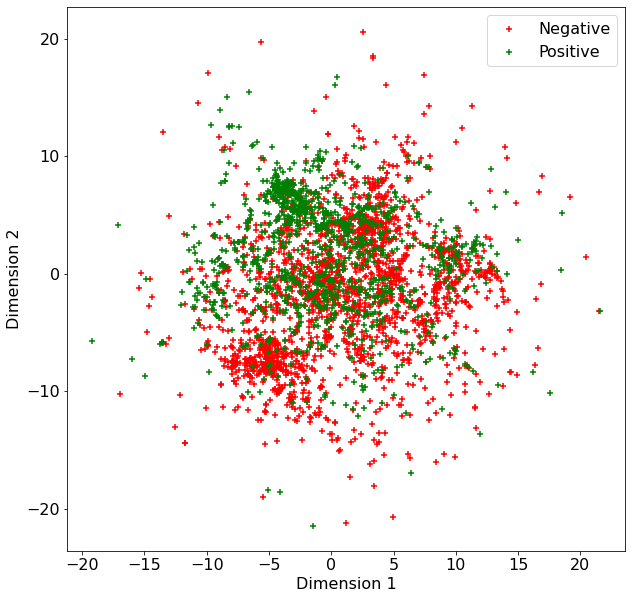

In [146]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(tsne_vectors[neg_inds,0], tsne_vectors[neg_inds,1], marker='+', c='r', label='Negative')
ax.scatter(tsne_vectors[pos_inds,0], tsne_vectors[pos_inds,1], marker='+', c='g', label='Positive')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

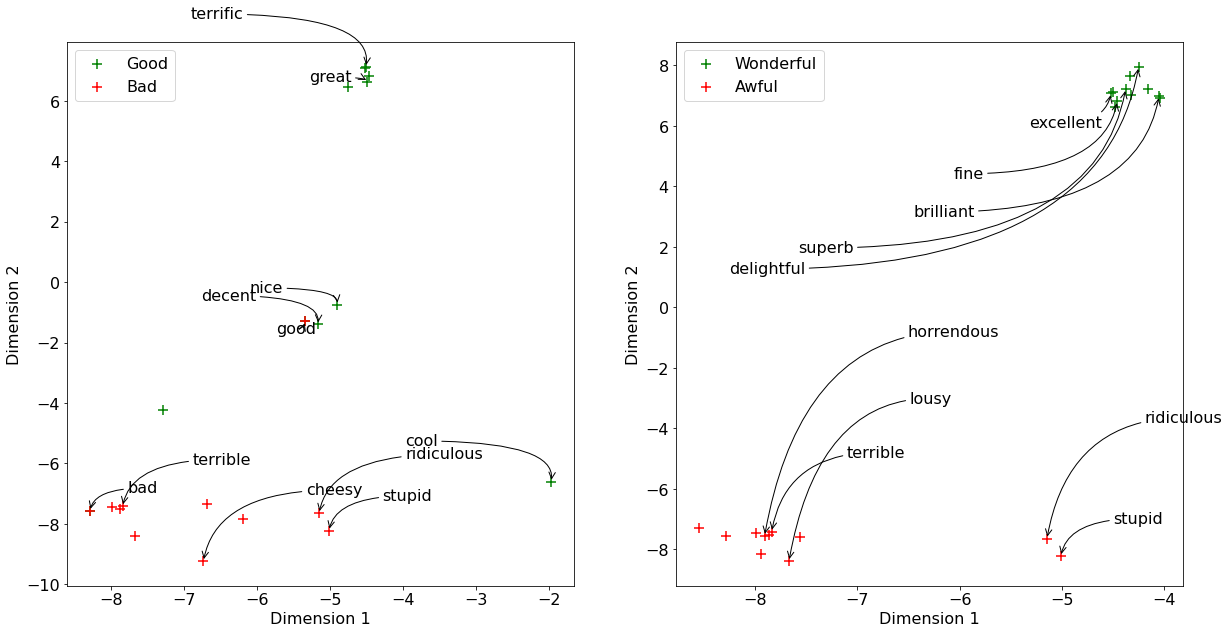

In [397]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

annotation_dist = 0.2
arrow_args = dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-100")

# ax[0].scatter(tsne_vectors[wonderful_inds,0], tsne_vectors[wonderful_inds,1], marker='+', s=75, c='b', label='Wonderful')
# ax[0].scatter(tsne_vectors[awful_inds,0], tsne_vectors[awful_inds,1], marker='+', s=75, c='orange', label='Awful')
# ax[0].scatter(tsne_vectors[good_inds,0], tsne_vectors[good_inds,1], marker='+', s=75, c='g', label='Good')
# ax[0].scatter(tsne_vectors[bad_inds,0], tsne_vectors[bad_inds,1], marker='+', s=75, c='r', label='Bad')
# ax[0].set_xlabel('Dimension 1')
# ax[0].set_ylabel('Dimension 2')
# ax[0].legend(loc='upper left')
# for w in ['wonderful', 'awful', 'good', 'bad']:
#     label_ind = np.where(tsne_labels == w)[0]
#     ax[0].annotate(tsne_labels[label_ind][0], (tsne_vectors[label_ind,0]+annotation_dist, tsne_vectors[label_ind,1]+annotation_dist))

ax[0].scatter(tsne_vectors[good_inds,0], tsne_vectors[good_inds,1], marker='+', s=100, c='g', label='Good')
ax[0].scatter(tsne_vectors[bad_inds,0], tsne_vectors[bad_inds,1], marker='+', s=100, c='r', label='Bad')
for i, j in enumerate(good_inds):
    if not i % 2:
        ax[0].annotate(tsne_labels[j],
        xy=(tsne_vectors[j,0], tsne_vectors[j,1]),
        xytext=(tsne_vectors[j,0]-i/5-2*annotation_dist, tsne_vectors[j,1]+i/5-2*annotation_dist),
        arrowprops=arrow_args,
        )
for i, j in enumerate(bad_inds):
    if i % 2:
        ax[0].annotate(tsne_labels[j],
        xy=(tsne_vectors[j,0], tsne_vectors[j,1]),
        xytext=(tsne_vectors[j,0]+i/9+2*annotation_dist, tsne_vectors[j,1]+i/5+2*annotation_dist),
        arrowprops=arrow_args,
        )
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend(loc='upper left')

ax[1].scatter(tsne_vectors[wonderful_inds,0], tsne_vectors[wonderful_inds,1], marker='+', s=100, c='g', label='Wonderful')
ax[1].scatter(tsne_vectors[awful_inds,0], tsne_vectors[awful_inds,1], marker='+', s=100, c='r', label='Awful')
for i, j in enumerate(wonderful_inds):
    if i % 2:
        ax[1].annotate(tsne_labels[j],
        xy=(tsne_vectors[j,0], tsne_vectors[j,1]),
        xytext=(tsne_vectors[j,0]-i/2.5-2*annotation_dist, tsne_vectors[j,1]-i/1.4-2*annotation_dist),
        arrowprops=arrow_args,
        )
for i, j in enumerate(awful_inds):
    if i % 2:
        ax[1].annotate(tsne_labels[j],
        xy=(tsne_vectors[j,0], tsne_vectors[j,1]),
        xytext=(tsne_vectors[j,0]+i/9+2*annotation_dist, tsne_vectors[j,1]+i/1.45+2*annotation_dist),
        arrowprops=arrow_args,
        )
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend(loc='upper left')

fig.savefig(os.path.join(plot_dir, 'tsne_selected_word_projections.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [290]:
# pos_visualisation_review_paths = ['imdb/train/pos/1002_7.txt', 'imdb/train/pos/2010_8.txt', 'imdb/train/pos/2989_10.txt']
pos_visualisation_review_paths = ['imdb/train/pos/2010_8.txt', 'imdb/train/pos/2989_10.txt']
pos_visualisation_review_gensim_inds = np.array([np.where(np.array(imdb_train_test_files) == p)[0] for p in pos_visualisation_review_paths]).flatten()

# neg_visualisation_review_paths = ['imdb/test/neg/2366_2.txt', 'imdb/train/neg/2000_3.txt', 'imdb/train/neg/1000_4.txt']
neg_visualisation_review_paths = ['imdb/train/neg/2000_3.txt', 'imdb/train/neg/1000_4.txt']
neg_visualisation_review_gensim_inds = np.array([np.where(np.array(imdb_train_test_files) == p)[0] for p in neg_visualisation_review_paths]).flatten()

imdb_predict_results[pos_visualisation_review_gensim_inds], imdb_predict_results[neg_visualisation_review_gensim_inds]

(array([ True,  True]), array([ True,  True]))

In [291]:
with open(pos_visualisation_review_paths[0]) as f:
    print(f.readlines()[0])

I thought this movie was pretty good. Some parts were corny but that's understandable since it was made more than 55 years ago. I thought the best performance in the movie was given by Michele Morgan who played Millie convincingly. Jack Haley is also really good as Mike O'Brien. Even though I'm not a big Frank Sinatra fan, I think he was very good in this movie. If your have a craving for a silly, over the top musical comedy, Higher and Higher is the movie for you.<br /><br />


In [292]:
with open(neg_visualisation_review_paths[0]) as f:
    print(f.readlines()[0])

I found the pace to be glacial and the original story blown way out of proportion to the content. My wife slept through most of it and I did not try to wake her because I felt she was not missing anything.<br /><br />When Holmes and Watson enter the house and then are potentially caught, it is unclear how they could hide all of their entry and burglary tools so quickly. It is also unclear how the door to the study is locked, preventing the servants from getting in.<br /><br />The thing that puzzled me was right at the end when there was a glint in the eye of the broken statute. I have no clue what this was supposed to represent.


In [243]:
list(np.argwhere(imdb_predict_results==False).flatten()[-10:])

[49906, 49915, 49920, 49923, 49937, 49951, 49956, 49959, 49982, 49988]

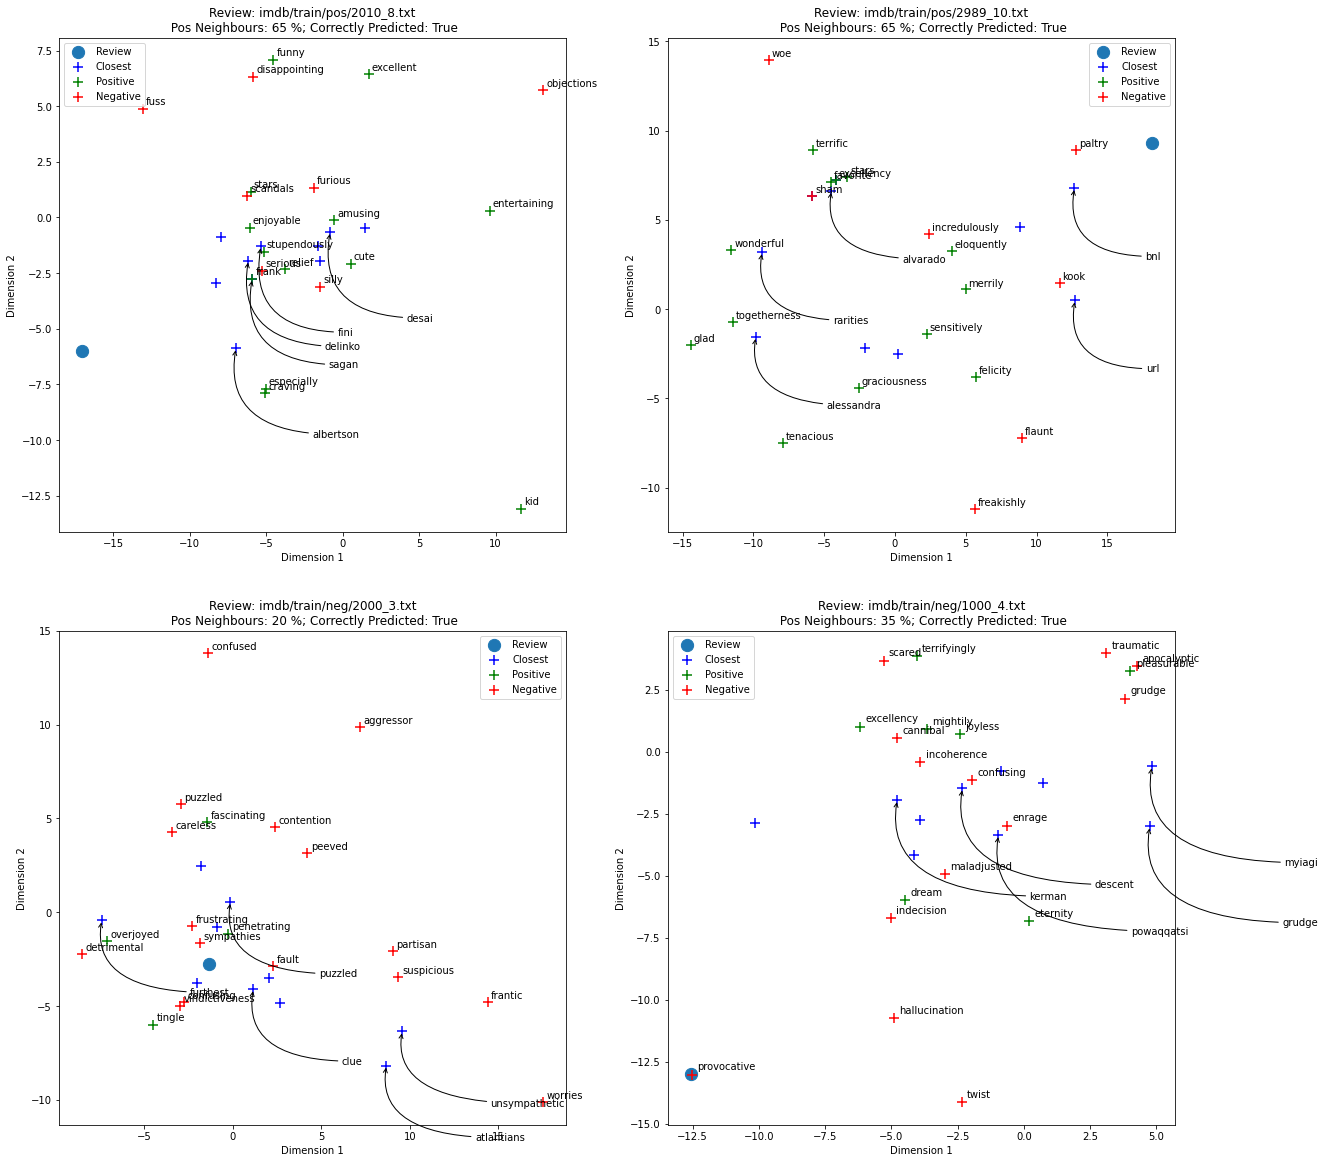

In [480]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))

arrow_args = dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-100")

for i, vis_tuple in enumerate([(pos_visualisation_review_paths, pos_visualisation_review_gensim_inds), (neg_visualisation_review_paths, neg_visualisation_review_gensim_inds)]):
    visualisation_review_paths, visualisation_review_gensim_inds = vis_tuple

    for j, visualisation_review_path in enumerate(visualisation_review_paths):
        train_test_ind = visualisation_review_gensim_inds[j]
        review_pred_correct = imdb_predict_results[train_test_ind]
        
        tsne_review_ind = np.where(tsne_reviews == visualisation_review_path)
        review_embedding = gensim_sklearn.pipeline.named_steps['doc2vec'].transform([visualisation_review_path])
        review_embedding_tsne = tsne_vectors[tsne_review_ind,:][0]

        review_closest_words = [w[0] for w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(review_embedding, topn=1000)]
        review_closest_words_mask = np.isin(tsne_labels, review_closest_words)
        review_closest_word_embeddings = tsne_vectors[review_closest_words_mask][:10,:]

        review_closest_lexicon_words = [w for w in review_closest_words if w in [*lexicon_pos_words, *lexicon_neg_words]][:20]
        review_closest_lexicon_words_mask = np.isin(tsne_labels, review_closest_lexicon_words)
        review_closest_lexicon_words_embeddings = tsne_vectors[review_closest_lexicon_words_mask]
        review_lexicon_labels = np.array([lexicon_dict[t][1] for t in review_closest_lexicon_words])

        ax[i,j].scatter(review_embedding_tsne[:,0], review_embedding_tsne[:,1], s=150, label='Review')

        ax[i,j].scatter(review_closest_word_embeddings[:,0], review_closest_word_embeddings[:,1], marker='+', s=100, c='b', label='Closest')
        for k in range(review_closest_word_embeddings.shape[0]):
            if k % 2:
                ax[i,j].annotate(review_closest_words[k],
                xy=(review_closest_word_embeddings[k,0], review_closest_word_embeddings[k,1]),
                xytext=(review_closest_word_embeddings[k,0]+5, review_closest_word_embeddings[k,1]-4),
                arrowprops=arrow_args,
                )

        plt_colors = {'positive':'green', 'negative':'red', 'neutral':'blue', 'both':'yellow'}
        for k in plt_colors.items():
            k_ind = np.where(review_lexicon_labels == k[0])
            if np.any(k_ind):
                ax[i,j].scatter(review_closest_lexicon_words_embeddings[k_ind,0], review_closest_lexicon_words_embeddings[k_ind,1], marker='+', s=100, c=k[1], label=k[0].title())
        for k in range(review_closest_lexicon_words_embeddings.shape[0]):
            ax[i,j].annotate(review_closest_lexicon_words[k], (review_closest_lexicon_words_embeddings[k,0]+0.2, review_closest_lexicon_words_embeddings[k,1]+0.2))

        ax[i,j].set_xlabel('Dimension 1')
        ax[i,j].set_ylabel('Dimension 2')
        ax[i,j].set_title(f'Review: {visualisation_review_path}\n Pos Neighbours: {int((review_lexicon_labels==SENTIMENTS.pos.lexicon_label).mean()*100)} %; Correctly Predicted: {review_pred_correct}')
        # ax[i].set_xlim(-1.25, 2)
        # ax[i].set_ylim(-1.25, 2)
        ax[i,j].legend()

fig.savefig(os.path.join(plot_dir, 'tsne_selected_review_projections.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [470]:
gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(review_embedding, topn=10)

[('powaqqatsi', 0.36133110523223877),
 ('cyberspace', 0.35916468501091003),
 ('myiagi', 0.34749674797058105),
 ('potente', 0.3441321551799774),
 ('kerman', 0.34124666452407837),
 ('materialize', 0.3392648696899414),
 ('grudge', 0.32820481061935425),
 ('descent', 0.32716721296310425),
 ('heterosexuals', 0.3250814974308014),
 ('cravens', 0.3243860602378845)]

## PCA

In [288]:
pca_embeddings = gensim_vectors
# pca_embeddings = np.vstack((lexicon_pos_word_embeddings, lexicon_neg_word_embeddings))

pca_2 = PCA(n_components=2)
pca_embeds_2d = pca_2.fit(pca_embeddings)
words_pca = pca_embeds_2d.transform(pca_embeddings)

# pca_3 = PCA(n_components=3)
# pca_embeds_3d = pca_3.fit(pca_embeddings)

pca_embeds_2d.explained_variance_ratio_.sum(), #pca_embeds_3d.explained_variance_ratio_

(0.02914294,)

In [469]:
fig, ax = plt.subplots(1, figsize=(10,10))   
ax.scatter(words_pca[neg_inds,0], words_pca[neg_inds,1], marker='+', c='r', label=SENTIMENTS.neg.lexicon_label.title())
ax.scatter(words_pca[pos_inds,0], words_pca[pos_inds,1], marker='+', c='g', label=SENTIMENTS.pos.lexicon_label.title())
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

<IPython.core.display.Javascript object>

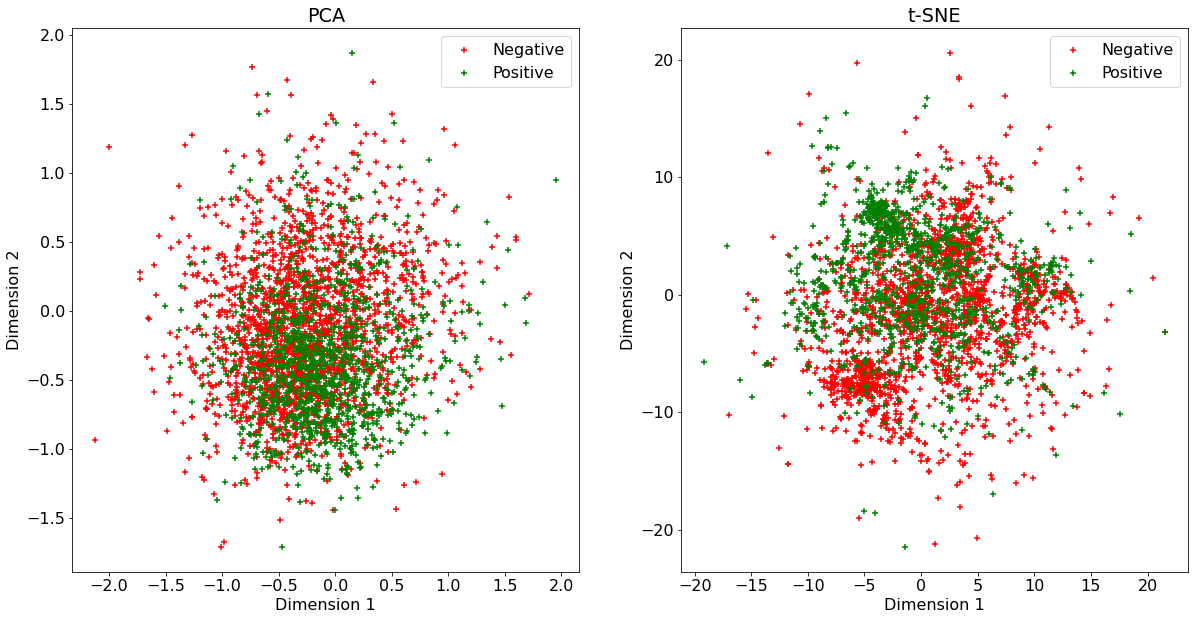

In [280]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))   

ax[0].scatter(words_pca[neg_inds,0], words_pca[neg_inds,1], marker='+', c='r', label=SENTIMENTS.neg.lexicon_label.title())
ax[0].scatter(words_pca[pos_inds,0], words_pca[pos_inds,1], marker='+', c='g', label=SENTIMENTS.pos.lexicon_label.title())
ax[0].set_title('PCA')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend()

ax[1].scatter(tsne_vectors[neg_inds,0], tsne_vectors[neg_inds,1], marker='+', c='r', label=SENTIMENTS.neg.lexicon_label.title())
ax[1].scatter(tsne_vectors[pos_inds,0], tsne_vectors[pos_inds,1], marker='+', c='g', label=SENTIMENTS.pos.lexicon_label.title())
ax[1].set_title('t-SNE')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend()

fig.savefig(os.path.join(plot_dir, 'pca_tsne_projections.jpeg'), pad_inches=0.2, bbox_inches='tight')

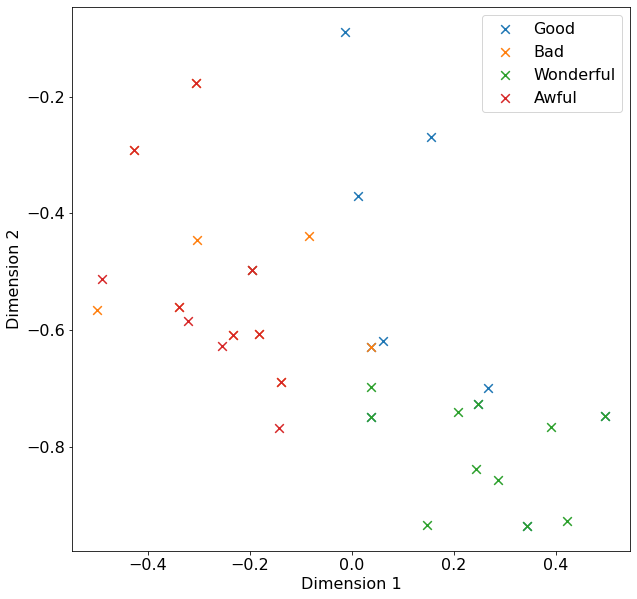

In [267]:
fig, ax = plt.subplots(1, figsize=(10,10))
for embed_tuple in [('Good', good_inds), ('Bad', bad_inds), ('Wonderful', wonderful_inds), ('Awful', awful_inds)]:
    label, inds = embed_tuple
    ax.scatter(words_pca[inds,0], words_pca[inds,1], marker='x', s=75, label=label)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

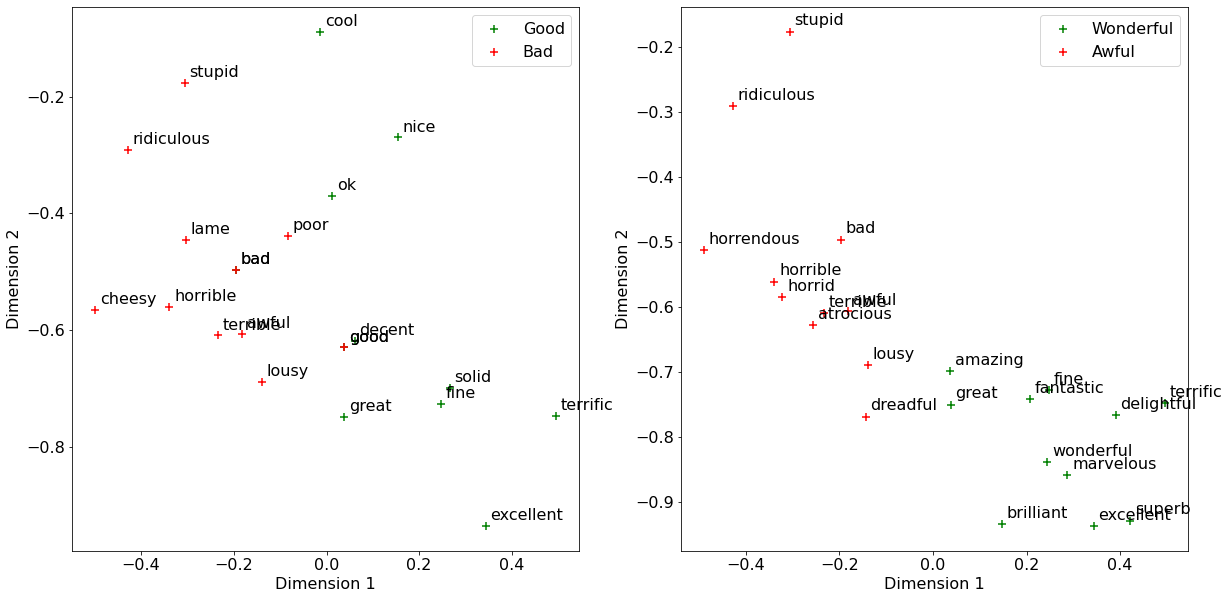

In [287]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

annotation_dist = 0.01

# ax[0].scatter(words_pca[wonderful_inds,0], words_pca[wonderful_inds,1], marker='+', s=75, c='b', label='Wonderful')
# ax[0].scatter(words_pca[awful_inds,0], words_pca[awful_inds,1], marker='+', s=75, c='orange', label='Awful')
# ax[0].scatter(words_pca[good_inds,0], words_pca[good_inds,1], marker='+', s=75, c='g', label='Good')
# ax[0].scatter(words_pca[bad_inds,0], words_pca[bad_inds,1], marker='+', s=75, c='r', label='Bad')
# ax[0].set_xlabel('Dimension 1')
# ax[0].set_ylabel('Dimension 2')
# ax[0].legend(loc='upper right')
# for w in ['wonderful', 'awful', 'good', 'bad']:
#     label_ind = np.where(gensim_labels == w)[0]
#     ax[0].annotate(gensim_labels[label_ind][0], (words_pca[label_ind,0]+annotation_dist, words_pca[label_ind,1]+annotation_dist))

ax[0].scatter(words_pca[good_inds,0], words_pca[good_inds,1], marker='+', s=75, c='g', label='Good')
ax[0].scatter(words_pca[bad_inds,0], words_pca[bad_inds,1], marker='+', s=75, c='r', label='Bad')
for i in good_inds:
    ax[0].annotate(gensim_labels[i], (words_pca[i,0]+annotation_dist, words_pca[i,1]+annotation_dist))
for i in bad_inds:
    ax[0].annotate(gensim_labels[i], (words_pca[i,0]+annotation_dist, words_pca[i,1]+annotation_dist))
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend(loc='upper right')

ax[1].scatter(words_pca[wonderful_inds,0], words_pca[wonderful_inds,1], marker='+', s=75, c='g', label='Wonderful')
ax[1].scatter(words_pca[awful_inds,0], words_pca[awful_inds,1], marker='+', s=75, c='r', label='Awful')
for i in wonderful_inds:
    ax[1].annotate(gensim_labels[i], (words_pca[i,0]+annotation_dist, words_pca[i,1]+annotation_dist))
for i in awful_inds:
    ax[1].annotate(gensim_labels[i], (words_pca[i,0]+annotation_dist, words_pca[i,1]+annotation_dist))
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend(loc='upper right')

fig.savefig(os.path.join(plot_dir, 'pca_selected_word_projections.jpeg'), pad_inches=0.2, bbox_inches='tight')

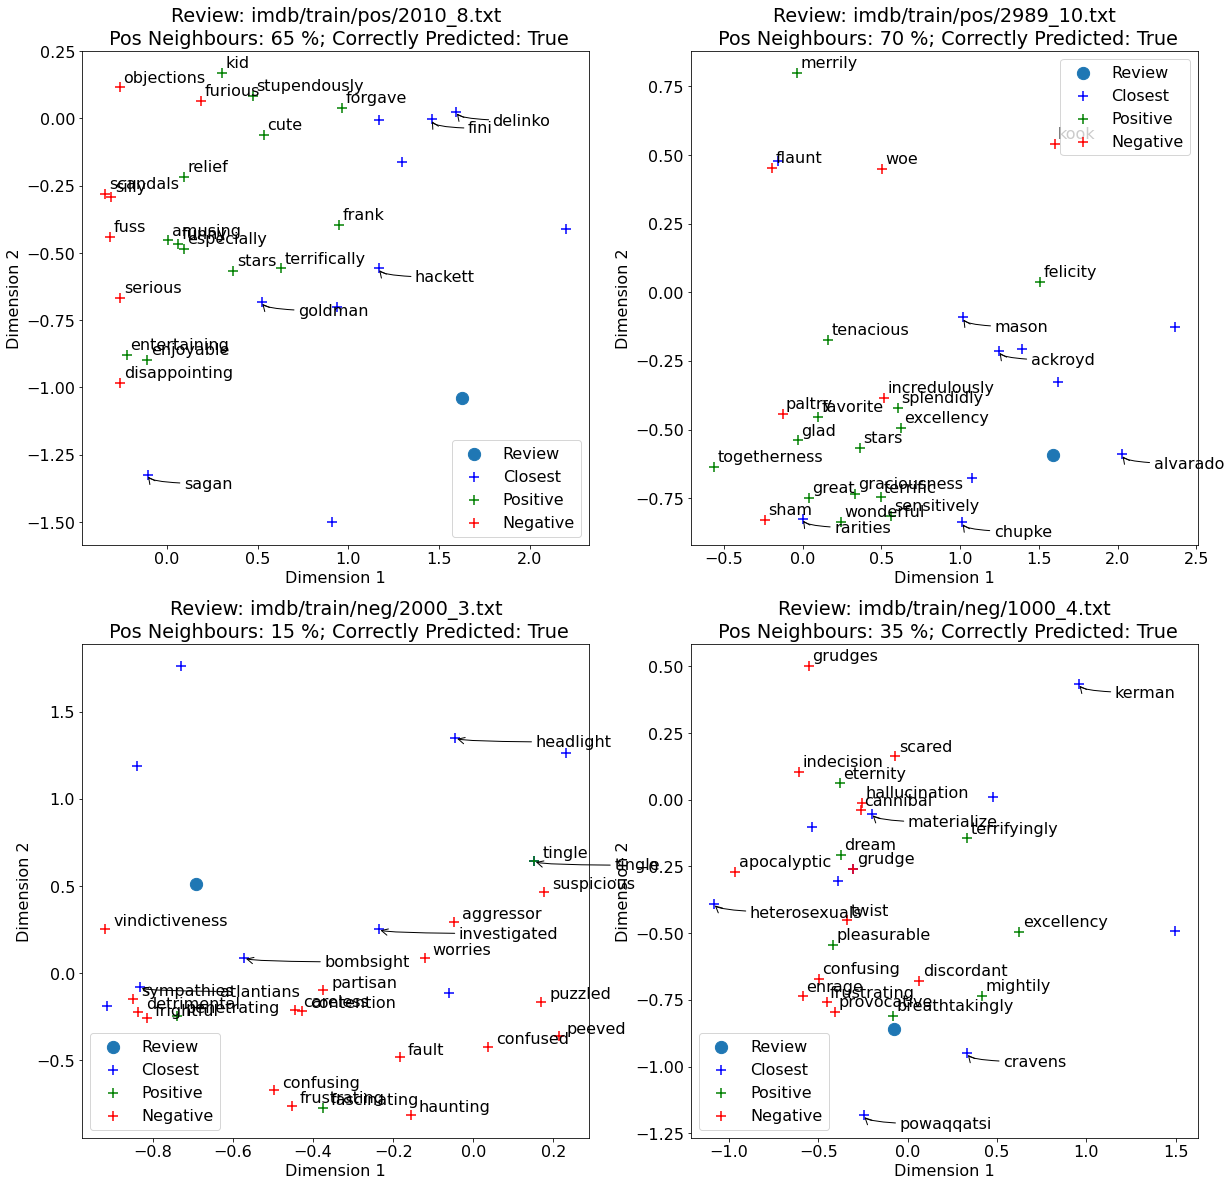

In [448]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))

annotation_dist = 0.02

for i, vis_tuple in enumerate([(pos_visualisation_review_paths, pos_visualisation_review_gensim_inds), (neg_visualisation_review_paths, neg_visualisation_review_gensim_inds)]):
    visualisation_review_paths, visualisation_review_gensim_inds = vis_tuple

    for j, visualisation_review_path in enumerate(visualisation_review_paths):
        train_test_ind = visualisation_review_gensim_inds[j]
        review_pred_correct = imdb_predict_results[train_test_ind]

        review_embedding = gensim_sklearn.pipeline.named_steps['doc2vec'].transform([visualisation_review_path])
        review_embedding_pca = pca_embeds_2d.transform(review_embedding)

        review_closest_words = [w[0] for w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(review_embedding, topn=1000)]
        review_closest_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in review_closest_words])[:10,:]
        review_closest_word_embeddings_pca = pca_embeds_2d.transform(review_closest_word_embeddings)

        review_closest_lexicon_words = [w for w in review_closest_words if w in [*lexicon_pos_words, *lexicon_neg_words]][:20]
        review_closest_lexicon_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in review_closest_lexicon_words])
        review_closest_lexicon_embeddings_pca = pca_embeds_2d.transform(review_closest_lexicon_embeddings)
        review_lexicon_labels = np.array([lexicon_dict[t][1] for t in review_closest_lexicon_words])

        ax[i,j].scatter(review_embedding_pca[:,0], review_embedding_pca[:,1], s=150, label='Review')

        ax[i,j].scatter(review_closest_word_embeddings_pca[:,0], review_closest_word_embeddings_pca[:,1], marker='+', s=100, c='b', label='Closest')
        for k in range(review_closest_word_embeddings_pca.shape[0]):
            if k % 2:
                ax[i,j].annotate(review_closest_words[k],
                xy=(review_closest_word_embeddings_pca[k,0], review_closest_word_embeddings_pca[k,1]),
                xytext=(review_closest_word_embeddings_pca[k,0]+0.2, review_closest_word_embeddings_pca[k,1]-0.05),
                arrowprops=arrow_args,
                )

        plt_colors = {'positive':'green', 'negative':'red', 'neutral':'blue', 'both':'yellow'}
        for k in plt_colors.items():
            k_ind = np.where(review_lexicon_labels == k[0])
            if np.any(k_ind):
                ax[i,j].scatter(review_closest_lexicon_embeddings_pca[k_ind,0], review_closest_lexicon_embeddings_pca[k_ind,1], marker='+', s=100, c=k[1], label=k[0].title())
        for k in range(review_closest_lexicon_embeddings_pca.shape[0]):
            ax[i,j].annotate(review_closest_lexicon_words[k], (review_closest_lexicon_embeddings_pca[k,0]+annotation_dist, review_closest_lexicon_embeddings_pca[k,1]+annotation_dist))

        ax[i,j].set_xlabel('Dimension 1')
        ax[i,j].set_ylabel('Dimension 2')
        ax[i,j].set_title(f'Review: {visualisation_review_path}\n Pos Neighbours: {int((review_lexicon_labels==SENTIMENTS.pos.lexicon_label).mean()*100)} %; Correctly Predicted: {review_pred_correct}')
        # ax[i,j].set_xlim(-1.25, 2)
        # ax[i,j].set_ylim(-1.25, 2)
        ax[i,j].legend()

fig.savefig(os.path.join(plot_dir, 'pca_selected_review_projections.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [148]:
# lexicon_pos_words_pca_3d = pca_embeds_3d.transform(np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_pos_words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]))
# lexicon_neg_words_pca_3d = pca_embeds_3d.transform(np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_neg_words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]))

# lexicon_pos_words_pca_df = pd.DataFrame(lexicon_pos_words_pca_3d)
# lexicon_pos_words_pca_df['sentiment'] = 'pos'

# lexicon_neg_words_pca_df = pd.DataFrame(lexicon_neg_words_pca_3d)
# lexicon_neg_words_pca_df['sentiment'] = 'neg'

# lexicon_pca_df = pd.concat((lexicon_pos_words_pca_df, lexicon_neg_words_pca_df))
# lexicon_pca_df['size'] = 0.8

# px.scatter_3d(lexicon_pca_df, x=0, y=1, z=2, color='sentiment', size='size')

### Pang et al words

In [ ]:
gensim_sklearn = GensimSVMSklearn(
    d2v_training_files=d2v_training_files,
    d2v_epochs=100,
    d2v_infer_epochs=50,
    d2v_min_count=5,
    d2v_vector_size=50,
    d2v_window=5,
    d2v_dm=0,
    d2v_dm_concat=0,
    d2v_dbow_words=1
)

In [ ]:
pang_positive_words = 'love wonderful best great superb still beautiful'.split()
pang_negative_words = 'bad worst stupid waste boring terrible awful'.split()

In [ ]:
pang_positive_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in pang_positive_words])
pang_negative_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in pang_negative_words])
pang_positive_word_embeddings.shape, pang_negative_word_embeddings.shape

In [ ]:
pang_positive_word_pca = pca_2.transform(pang_positive_word_embeddings)
pang_negative_word_pca = pca_2.transform(pang_negative_word_embeddings)

In [ ]:
pos_doc_ind = 10
neg_doc_ind = 10
pos_doc_pca = pca_2.transform(training_pos_embeddings[pos_doc_ind,:][None,:])[0]
neg_doc_pca = pca_2.transform(training_neg_embeddings[neg_doc_ind,:][None,:])[0]

In [ ]:
plt.scatter(pang_positive_word_pca[:,0], pang_positive_word_pca[:,1], marker='x', label='pos')
plt.scatter(pang_negative_word_pca[:,0], pang_negative_word_pca[:,1], marker='x', label='neg')
plt.scatter(pos_doc_pca[0], pos_doc_pca[1], marker='x', label='pos_doc')
plt.scatter(neg_doc_pca[0], neg_doc_pca[1], marker='x', label='neg_doc')
plt.legend()
for word, (x,y) in zip([*pang_positive_words, *pang_negative_words], np.vstack((pang_positive_word_pca, pang_negative_word_pca))):
    plt.text(x+0.05, y+0.05, word)